<div align='center'>

# Linear Algebra Fundamentals - Part 2

### Part of Scientific-ML-Notes 

[![GitHub](https://img.shields.io/badge/GitHub-Repository-black?logo=github&scale=5)](https://github.com/mhnaderi/Scientific-ML-Notes)

---

In [1]:
# Import necessary libraries and set up the notebook environment
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

# Define a class for 3D arrows
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

# Numerics Interlude

## Condition Number

The **condition number** of a matrix $A$ measures the sensitivity of the solution of a linear system involving $A$ to small changes or errors in the input data. It is defined as:

$$
\operatorname{cond}(A) = \frac{\sigma_{\max}(A)}{\sigma_{\min}(A)} = \| A \|_2 \left\| A^{-1} \right\|_2,
$$

where $\sigma_{\max}(A)$ and $\sigma_{\min}(A)$ are the largest and smallest singular values of $A$, respectively.

Key properties of the condition number:

- For any matrix $A$, $\operatorname{cond}(A) \geq 1$.
- For the identity matrix $I$, $\operatorname{cond}(I) = 1$.
- Scaling a matrix by a non-zero scalar $\gamma$ does not change its condition number: $\operatorname{cond}(\gamma A) = \operatorname{cond}(A)$.
- For a diagonal matrix $D = \operatorname{diag}(d_i)$, the condition number is $\operatorname{cond}(D) = \dfrac{\max |d_i|}{\min |d_i|}$.

A large condition number indicates that $A$ is nearly singular, meaning that it is close to being non-invertible and the system is highly sensitive to perturbations.

The condition number provides an error bound for the approximate solution to a linear system $A \mathbf{x} = \mathbf{b}$:

$$
\frac{\| \Delta \mathbf{x} \|}{\| \mathbf{x} \|} \leq \operatorname{cond}(A) \frac{\| \Delta \mathbf{b} \|}{\| \mathbf{b} \|},
$$

where $\Delta \mathbf{x}$ and $\Delta \mathbf{b}$ represent the errors in the solution and the data, respectively. This inequality quantifies how errors in the input $\mathbf{b}$ can affect the solution $\mathbf{x}$.

In practice, a computed solution can lose up to $\log_{10}(\operatorname{cond}(A))$ decimal digits of accuracy relative to the accuracy of the input data.

**Note:** It's generally advisable for all entries and their associated uncertainties in a matrix to have similar magnitudes to reduce the condition number and improve numerical stability.

## Well-Posed Problems

A mathematical problem is considered **well-posed** if:

1. A solution exists.
2. The solution is unique.
3. The solution's behavior changes continuously with changes in the input data.

If any of these conditions fail, the problem is deemed **ill-posed**. Even when a problem is well-posed, the solution might still be highly sensitive to small perturbations in the input, especially if the condition number is large.

## Machine Precision

In floating-point arithmetic, rounding errors are unavoidable due to finite precision. The computed value $\tilde{x}$ is related to the exact value $x$ by:

$$
\tilde{x} = \mathrm{fl}(x),
$$

where $\mathrm{fl}(\cdot)$ denotes the floating-point representation. According to the IEEE standard:

- **Single Precision**: Approximately 7 decimal digits of accuracy.
- **Double Precision**: Approximately 16 decimal digits of accuracy.
- **Quadruple Precision**: Approximately 34 decimal digits of accuracy.

Understanding machine precision is crucial for assessing and managing numerical errors in computations.

## Stability

The stability of an algorithm refers to its ability to produce accurate results despite errors introduced during computation. Specifically:

- An **algorithm is stable** if its output is close to the exact solution of a nearby problem.
- A **backward stable algorithm** produces the exact solution to a slightly perturbed version of the original problem.

Essentially, a stable algorithm should not amplify the inherent sensitivity of the problem.

For functions $f$ and algorithms $\tilde{f}$ defined on finite-dimensional spaces $X$ and $Y$, the concepts of accuracy, stability, and backward stability are independent of the norms chosen for $X$ and $Y$.

If a backward stable algorithm is used to solve a problem $f: X \rightarrow Y$ with condition number $\kappa$, the relative error satisfies:

$$
\frac{\| \tilde{f}(x) - f(x) \|}{\| f(x) \|} = O\left( \kappa(x) \, \varepsilon_{\text{machine}} \right),
$$

where $\varepsilon_{\text{machine}}$ denotes the machine precision.

## Condition Number for Continuous and Differentiable Functions

For a continuously differentiable function $f: X \rightarrow Y$, the **Jacobian matrix** $J(x)$ at a point $x$ contains the partial derivatives:

$$
[J(x)]_{ij} = \left. \frac{\partial f_i}{\partial x_j} \right|_{x}.
$$

The **absolute condition number** is:

$$
\hat{\kappa} = \| J(x) \|,
$$

where $\| J(x) \|$ is the norm of the Jacobian matrix induced by the norms on $X$ and $Y$.

The **relative condition number** is:

$$
\kappa = \frac{\| J(x) \| \cdot \| x \|}{\| f(x) \|}.
$$

Some functions, like the square root, can have condition numbers less than one, indicating that relative changes in the input result in smaller relative changes in the output. However, due to rounding errors in floating-point arithmetic (of magnitude $\varepsilon_{\text{machine}}$), condition numbers less than one do not improve accuracy beyond machine precision. While both absolute and relative condition numbers are important, relative condition numbers are often more relevant in numerical analysis because floating-point arithmetic introduces errors at the relative level. 

A problem is considered **well-conditioned** if $\kappa$ is small (e.g., $1$, $10$, $10^2$) and **ill-conditioned** if $\kappa$ is large (e.g., $10^6$, $10^{16}$).
**Implications:**

- If $\kappa_f \approx 10^d$, we may lose up to $d$ decimal digits of accuracy when computing $f(x)$.
- If $\kappa_f \approx 1 / \varepsilon_{\text{machine}}$, the computed result may differ by as much as $100\%$ simply due to finite precision in representing $x$.

# Matrix Decomposition

## QR Decomposition

In various applications, analyzing the column spaces of a matrix $A$ is essential. Specifically, we are interested in the sequence of subspaces spanned by its columns $\mathbf{a}_1, \mathbf{a}_2, \dots$:

$$
\langle \mathbf{a}_1 \rangle \subseteq \langle \mathbf{a}_1, \mathbf{a}_2 \rangle \subseteq \langle \mathbf{a}_1, \mathbf{a}_2, \mathbf{a}_3 \rangle \subseteq \dots
$$

The **QR factorization** is a technique that constructs a sequence of orthonormal vectors $\mathbf{q}_1, \mathbf{q}_2, \dots$ to span these successive subspaces. Assuming $A \in \mathbb{R}^{m \times n}$ with $m \geq n$ and full rank $n$, we aim for:

$$
\langle \mathbf{q}_1, \mathbf{q}_2, \dots, \mathbf{q}_j \rangle = \langle \mathbf{a}_1, \mathbf{a}_2, \dots, \mathbf{a}_j \rangle, \quad \text{for } j = 1, \dots, n.
$$

This ensures that each subspace spanned by the first $j$ orthonormal vectors $\mathbf{q}_1, \dots, \mathbf{q}_j$ coincides with the subspace spanned by the first $j$ columns of $A$.

Consequently, the columns $\mathbf{a}_1, \dots, \mathbf{a}_n$ can be expressed as linear combinations of $\mathbf{q}_1, \dots, \mathbf{q}_n$. The invertibility of the upper-left $k \times k$ block of the resulting triangular matrix guarantees that $\mathbf{q}_1, \dots, \mathbf{q}_n$ can also be represented in terms of $\mathbf{a}_1, \dots, \mathbf{a}_n$.

The relationship is captured in the **reduced QR factorization**:

$$
A = \hat{Q} \hat{R},
$$

where:

- $\hat{Q}$ is an $m \times n$ matrix with orthonormal columns,
- $\hat{R}$ is an $n \times n$ upper triangular matrix.

For the **full QR factorization**, we augment $\hat{Q}$ with $m - n$ additional orthonormal columns to form an $m \times m$ orthogonal matrix $Q$. Simultaneously, we extend $\hat{R}$ by adding rows of zeros to create an $m \times n$ matrix $R$, which remains upper triangular in its leading $n \times n$ block.

In summary:

- **Reduced QR Factorization**:

  - $A = \hat{Q} \hat{R}$,
  - $\hat{Q} \in \mathbb{R}^{m \times n}$ with orthonormal columns,
  - $\hat{R} \in \mathbb{R}^{n \times n}$ is upper triangular.

- **Full QR Factorization**:

  - $A = Q R$,
  - $Q \in \mathbb{R}^{m \times m}$ is an orthogonal matrix ($Q^T Q = I$),
  - $R \in \mathbb{R}^{m \times n}$ has zeros in its bottom $m - n$ rows.

Every matrix $A \in \mathbb{R}^{m \times n}$ with $m \geq n$ admits both a full and a reduced QR factorization. If $A$ has full rank $n$, the reduced QR factorization $A = \hat{Q} \hat{R}$ is unique when the diagonal entries of $\hat{R}$ are positive ($r_{ii} > 0$).

### Gram-Schmidt Orthogonalization

The **Gram-Schmidt process** converts a set of linearly independent vectors into an orthogonal (or orthonormal) set spanning the same subspace. This is fundamental in constructing orthogonal bases.

Given linearly independent vectors $\{\mathbf{v}_1, \mathbf{v}_2, \dots, \mathbf{v}_n\}$:

1. **Initialize**:

   - Set $\mathbf{u}_1 = \mathbf{v}_1$.

2. **Iterate** for $i = 2$ to $n$:

   - Set $\mathbf{u}_i = \mathbf{v}_i$.
   - For $j = 1$ to $i - 1$:

     - Subtract the projection of $\mathbf{v}_i$ onto $\mathbf{u}_j$:

       $$
       \mathbf{u}_i = \mathbf{u}_i - \left( \frac{\mathbf{u}_j^\top \mathbf{v}_i}{\mathbf{u}_j^\top \mathbf{u}_j} \right) \mathbf{u}_j.
       $$

3. **Optional Normalization**:

   - Normalize each $\mathbf{u}_i$ to obtain orthonormal vectors:

     $$
     \mathbf{q}_i = \frac{\mathbf{u}_i}{\| \mathbf{u}_i \|}.
     $$

The resulting set $\{\mathbf{u}_1, \mathbf{u}_2, \dots, \mathbf{u}_n\}$ is orthogonal, and $\{\mathbf{q}_1, \mathbf{q}_2, \dots, \mathbf{q}_n\}$ is orthonormal. These vectors span the same subspace as the original $\{\mathbf{v}_1, \dots, \mathbf{v}_n\}$.

### QR Decomposition in SciPy

The `scipy` library offers efficient functions for computing and updating QR decompositions:

- **Compute QR Decomposition**:

  - `scipy.linalg.qr(A)` computes the QR factorization of matrix $A$.

- **Rank-k Updates**:

  - `scipy.linalg.qr_update(Q, R, u, v)` performs a rank-k update to the QR decomposition when rows or columns are added.

- **Deleting Rows or Columns**:

  - `scipy.linalg.qr_delete(Q, R, k, which)` efficiently updates the QR decomposition when a row or column is removed from $A$.

- **Inserting Rows or Columns**:

  - `scipy.linalg.qr_insert(Q, R, u, k, which)` updates the QR decomposition when a row or column is inserted into $A$.

These functions allow for modifying QR decompositions without recomputing from scratch, enhancing computational efficiency, especially for large matrices.

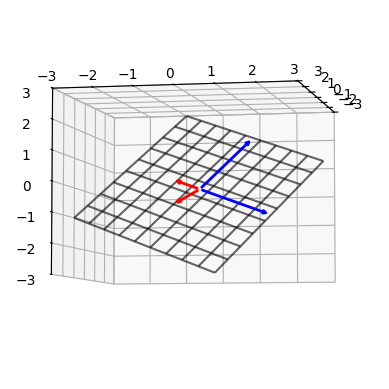

In [2]:
# Define matrix A
A = np.array([[ 1, -2],
              [ 2,  1],
              [-1,  2]])

# Perform QR decomposition
Q = np.linalg.qr(A)[0]

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot the plane defined by A
a1, a2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10))
ax.plot_wireframe(-a1-2*a2, -2*a1+a2, a1+2*a2, linewidth=1.5, color='k', alpha=.6)

# Plot columns of A
arw1 = Arrow3D([0, A[0, 0]], [0, A[1, 0]], [0, A[2, 0]], arrowstyle="->", color="b", lw=2, mutation_scale=5)
ax.add_artist(arw1)
arw2 = Arrow3D([0, A[0, 1]], [0, A[1, 1]], [0, A[2, 1]], arrowstyle="->", color="b", lw=2, mutation_scale=5)
ax.add_artist(arw2)

# Plot columns of Q
arw1 = Arrow3D([0, Q[0, 0]], [0, Q[1, 0]], [0, Q[2, 0]], arrowstyle="->", color="r", lw=2, mutation_scale=5)
ax.add_artist(arw1)
arw2 = Arrow3D([0, Q[0, 1]], [0, Q[1, 1]], [0, Q[2, 1]], arrowstyle="->", color="r", lw=2, mutation_scale=5)
ax.add_artist(arw2)

# Set plot limits
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)

# Set view angle
ax.view_init(-5, 12)

plt.show()

### From Vectors to Continuous Functions

The concept of QR factorization extends naturally to function spaces, allowing for orthonormal expansions of functions rather than just vectors. Let's consider substituting the finite-dimensional space $\mathbb{R}^m$ with the infinite-dimensional space $L^2[-1,1]$, which consists of all square-integrable complex-valued functions defined on the interval $[-1,1]$. While we'll skip the formal properties of this space, the inner product between two functions $f$ and $g$ in this context is defined as:

$$
\langle f, g \rangle = \int_{-1}^{1} \overline{f(x)} \, g(x) \, dx.
$$

As an illustrative example, consider the following "matrix" composed of monomial functions:

$$
A = [ \, 1 \, \mid \, x \, \mid \, x^2 \, \mid \, \dots \, \mid \, x^{n-1} \, ].
$$

Here, each "column" represents a function $x^j$ within $L^2[-1,1]$. Unlike traditional matrices where entries are discrete numbers, this "matrix" is continuous in the vertical direction since the functions are defined over a continuous interval. Essentially, it's a continuous counterpart to the classic Vandermonde matrix.

By applying the Gram-Schmidt process to these monomial functions, we obtain an orthonormal set of polynomials $\{ q_j(x) \}_{j=0}^{n-1}$ with respect to the defined inner product:

$$
\int_{-1}^{1} \overline{q_i(x)} \, q_j(x) \, dx = \delta_{ij} = \begin{cases} 1 & \text{if } i = j, \\ 0 & \text{if } i \ne j. \end{cases}
$$

These orthonormal polynomials $q_j(x)$ are proportional to the **Legendre polynomials** $P_j(x)$, which are normalized such that $P_j(1) = 1$. The initial Legendre polynomials are:

$$
\begin{align*}
P_0(x) &= 1, \\
P_1(x) &= x, \\
P_2(x) &= \tfrac{1}{2} (3 x^2 - 1), \\
P_3(x) &= \tfrac{1}{2} (5 x^3 - 3 x).
\end{align*}
$$

Similar to the monomials $1, x, x^2, \dots$, the Legendre polynomials span the space of polynomials of increasing degree. However, their orthogonality makes them particularly advantageous for computations, especially in methods like **spectral methods** used for numerically solving partial differential equations.

The "projection operator" associated with the orthonormal functions $\{ q_j(x) \}$ can be viewed as mapping any function $f(x) \in L^2[-1,1]$ onto the subspace spanned by $\{ q_j(x) \}$:

$$
f(x) \mapsto \sum_{j=0}^{n-1} q_j(x) \int_{-1}^{1} \overline{q_j(t)} \, f(t) \, dt.
$$

This operator acts similarly to the projection matrix $\hat{Q} \hat{Q}^T$ in finite-dimensional spaces, projecting functions in $L^2[-1,1]$ onto a finite-dimensional subspace.

### Solving $A \mathbf{x} = \mathbf{b}$ Using QR Factorization

Suppose we need to solve the linear system $A \mathbf{x} = \mathbf{b}$ for $\mathbf{x}$, where $A \in \mathbb{R}^{m \times m}$ is a nonsingular matrix. If we have the QR factorization of $A$, namely $A = Q R$, we can rewrite the system as:

$$
Q R \mathbf{x} = \mathbf{b} \quad \Rightarrow \quad R \mathbf{x} = Q^T \mathbf{b}.
$$

Since $Q$ is an orthogonal matrix ($Q^T Q = I$), computing $Q^T \mathbf{b}$ is straightforward. The matrix $R$ is upper triangular, making the system $R \mathbf{x} = Q^T \mathbf{b}$ easy to solve using back-substitution.

The steps to solve $A \mathbf{x} = \mathbf{b}$ using QR factorization are:

1. **Compute the QR factorization**: $A = Q R$.
2. **Compute**: $\mathbf{y} = Q^T \mathbf{b}$.
3. **Solve**: $R \mathbf{x} = \mathbf{y}$ for $\mathbf{x}$.

This method is also effective for solving **least-squares problems**, as it helps find the best approximate solution when an exact solution doesn't exist.

**Computational Cost:** The QR decomposition of an $m \times n$ matrix requires approximately $\mathcal{O}\left(2 m n^2 - \dfrac{2}{3} n^3\right)$ operations. The QR method is generally stable and reliable, potentially failing only when the condition number of $A$ approaches $1 / \varepsilon_{\text{machine}}$ or worse, where $\varepsilon_{\text{machine}}$ is the machine precision.

## Singular Value Decomposition (SVD)

The **Singular Value Decomposition** (SVD) of an $m \times n$ matrix $A$ expresses $A$ as the product of three matrices:

$$
A = U \Sigma V^T
$$

where:

- $U$ is an $m \times m$ orthogonal matrix whose columns $\mathbf{u}_i$ are the **left singular vectors** of $A$,
- $V$ is an $n \times n$ orthogonal matrix whose columns $\mathbf{v}_i$ are the **right singular vectors** of $A$,
- $\Sigma$ is an $m \times n$ diagonal matrix with non-negative real numbers $\sigma_i$ on the diagonal, known as the **singular values** of $A$.

The singular values are ordered such that:

$$
\sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_r > 0,
$$

where $r = \operatorname{rank}(A)$ is the number of non-zero singular values. The singular values of $A$ are uniquely determined and are the square roots of the eigenvalues of $A^T A$ (or $A A^T$):

$$
\sigma_i = \sqrt{\lambda_i}, \quad \text{for } i = 1, 2, \dots, r,
$$

where $\lambda_i$ are the eigenvalues of $A^T A$. The singular vectors are determined up to sign when the singular values are distinct. Moreover, the singular values correspond to the lengths of the vectors $A \mathbf{v}_i$:

$$
A \mathbf{v}_i = \sigma_i \mathbf{u}_i.
$$

### Low-Rank Approximation

The matrix $A$ can be represented as a sum of $r$ rank-one matrices:

$$
A = \sum_{i=1}^r \sigma_i \mathbf{u}_i \mathbf{v}_i^T.
$$

For any integer $\nu$ satisfying $0 \leq \nu \leq r$, the partial sum:

$$
A_\nu = \sum_{i=1}^\nu \sigma_i \mathbf{u}_i \mathbf{v}_i^T
$$

provides the best rank-$\nu$ approximation to $A$, minimizing the error in both the 2-norm and the Frobenius norm. The approximation error in the Frobenius norm is given by:

$$
\| A - A_\nu \|_F = \sqrt{\sigma_{\nu+1}^2 + \sigma_{\nu+2}^2 + \dots + \sigma_r^2}.
$$

### Properties of the SVD

- **Rank**: The number of non-zero singular values equals the rank of $A$.
- **Norms**:
  - 2-Norm: $\| A \|_2 = \sigma_1$.
  - Frobenius Norm: $\| A \|_F = \sqrt{\sigma_1^2 + \sigma_2^2 + \dots + \sigma_r^2}$.
- **Eigenvalues**: The non-zero singular values are the square roots of the non-zero eigenvalues of $A^T A$ and $A A^T$.
- **Symmetric Matrices**: If $A$ is symmetric ($A = A^T$), the singular values are the absolute values of the eigenvalues of $A$.
- **Determinant**: For square $A \in \mathbb{R}^{m \times m}$,
  
  $$
  |\det(A)| = \prod_{i=1}^m \sigma_i.
  $$

- **Pseudoinverse**: The pseudoinverse of $A$ is:

  $$
  A^{+} = V \Sigma^{+} U^T,
  $$

  where $\Sigma^{+}$ is formed by taking reciprocals of the non-zero singular values in $\Sigma$ and transposing.

  The minimum-norm solution to $A \mathbf{x} = \mathbf{b}$ is $\mathbf{x} = A^{+} \mathbf{b}$.

- **Condition Number**: The Euclidean condition number is:

  $$
  \operatorname{cond}(A) = \frac{\sigma_{\text{max}}}{\sigma_{\text{min}}}.
  $$

- **Uniqueness**: The SVD is unique up to the signs of the singular vectors.

- **Principal Component Analysis (PCA)**: Applying SVD to a mean-centered data matrix $\mathbf{X}$ yields the principal components of the data.

### Applications of the SVD

- **Rank Determination**: Counting the number of significant singular values helps determine the effective rank of $A$.
- **Orthonormal Bases**: SVD provides accurate methods for finding orthonormal bases for the range and null space of $A$.
- **Norm Computation**: SVD is used to compute $\| A \|_2$ and provides standards for low-rank approximations with respect to both the 2-norm and Frobenius norm.
- **Least Squares Problems**: It is instrumental in robust algorithms for least squares fitting, especially when $A$ is ill-conditioned.
- **Regularization and Subspace Intersections**: SVD aids in regularizing ill-posed problems and finding intersections of subspaces.

### Computing the SVD

A naive method to compute the SVD involves:

1. Forming $A^T A$.
2. Computing the eigenvalue decomposition: $A^T A = V \Lambda V^T$.
3. Constructing $\Sigma$ by taking square roots of the eigenvalues in $\Lambda$.
4. Solving $A V = U \Sigma$ for $U$.

However, this approach is numerically unstable due to the squaring of the condition number in $A^T A$. A more stable method involves:

- Reducing $A$ to bidiagonal form using orthogonal transformations.
- Applying iterative algorithms to compute the SVD of the bidiagonal matrix without forming large intermediate matrices.

The computational complexity of the SVD for an $m \times n$ matrix is approximately:

$$
\mathcal{O}\left( \min(m n^2, m^2 n) \right).
$$

### Invariance Under Unitary Transformations

An important property of the SVD is its invariance under unitary transformations:

- If $\mathbf{C}$ is an $m \times m$ unitary matrix and $\mathbf{P}$ is an $n \times n$ unitary matrix, then the SVD of $\mathbf{Y} = \mathbf{C} \mathbf{X} \mathbf{P}^T$ is:

  $$
  \mathbf{Y} = (\mathbf{C} \mathbf{U}) \Sigma (\mathbf{P} \mathbf{V})^T,
  $$

  where $\mathbf{X} = \mathbf{U} \Sigma \mathbf{V}^T$ is the SVD of $\mathbf{X}$.

- **Implication**: Singular values remain unchanged under unitary transformations, while the singular vectors are transformed accordingly.

For instance, since the discrete Fourier transform (DFT) is unitary, the SVD of the transformed data $\hat{\mathbf{X}} = \mathcal{F} \mathbf{X}$ has the same singular values as $\mathbf{X}$, with the left singular vectors transformed by the DFT:

$$
\hat{\mathbf{U}} = \mathcal{F} \mathbf{U}.
$$

This property is valuable in applications like compressed sensing and signal processing, where data may be analyzed in different bases without altering the intrinsic properties captured by the singular values.

[ 70.27036302  85.2226437  100.        ]


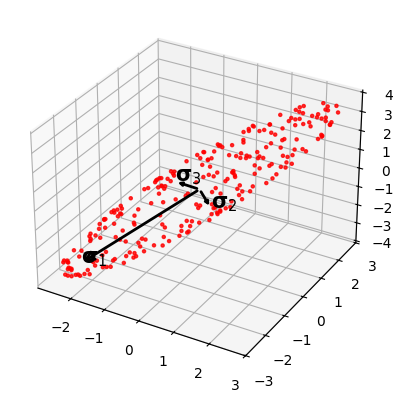

In [3]:
N = 250 
a, b, c = 5, 1, 1

# Generate random points on a sphere
u = np.random.rand(N)
v = np.random.rand(N)
theta = u * 2.0 * np.pi
phi = np.arccos(2.0 * v - 1.0)
sinTheta = np.sin(theta)
cosTheta = np.cos(theta)
sinPhi = np.sin(phi)
cosPhi = np.cos(phi)
rx = a * sinPhi * cosTheta
ry = b * sinPhi * sinTheta
rz = c * cosPhi
X  = np.vstack((rx, ry, rz))

# Define rotation matrices
R2 = np.array([[np.cos(np.pi/4), 0, -np.sin(np.pi/4)], 
               [0,               1,  0              ], 
               [np.sin(np.pi/4), 0,  np.cos(np.pi/4)]])

R3 = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4), 0], 
               [np.sin(np.pi/4),  np.cos(np.pi/4), 0], 
               [0,                0,               1]])

# Apply rotations to the points
X = R3 @ R2 @ X

# Perform Singular Value Decomposition (SVD)
U, S, Vh = np.linalg.svd(X)
print(np.cumsum(S)/np.sum(S)*100)
S, V = np.diag(S), Vh.T
Uhat = U[:, [0]]
Xhat = Uhat @ Uhat.T @ X

# Plot the points and singular vectors
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[0, :], X[1, :], X[2, :], c='r', s=5, alpha=.8)

# Plot singular vectors
arw1 = Arrow3D([0, .1 * S[0, 0] * U[0, 0]], [0, .1 * S[0, 0] * U[1, 0]], [0, .1 * S[0, 0] * U[2, 0]], arrowstyle="->", color="k", lw=2, mutation_scale=15)
ax.add_artist(arw1)
arw2 = Arrow3D([0, .1 * S[1, 1] * U[0, 1]], [0, .1 * S[1, 1] * U[1, 1]], [0, .1 * S[1, 1] * U[2, 1]], arrowstyle="->", color="k", lw=2, mutation_scale=5)
ax.add_artist(arw2)
arw3 = Arrow3D([0, .1 * S[2, 2] * U[0, 2]], [0, .1 * S[2, 2] * U[1, 2]], [0, .1 * S[2, 2] * U[2, 2]], arrowstyle="->", color="k", lw=2, mutation_scale=5)
ax.add_artist(arw3)
ax.text(.1 * S[0, 0] * U[0, 0], .1 * S[0, 0] * U[1, 0], .1 * S[0, 0] * U[2, 0], '$\mathbf{\sigma}_1$', fontsize=15)
ax.text(.1 * S[1, 1] * U[0, 1], .1 * S[1, 1] * U[1, 1], .1 * S[1, 1] * U[2, 1], '$\mathbf{\sigma}_2$', fontsize=15)
ax.text(.1 * S[2, 2] * U[0, 2], .1 * S[2, 2] * U[1, 2], .1 * S[2, 2] * U[2, 2], '$\mathbf{\sigma}_3$', fontsize=15)

plt.show()

### Optimal Hard Threshold

Deciding how many singular values to keep, i.e., where to truncate, is one of the most important and contentious decisions when using the SVD. There are many factors, including specifications on the desired rank of the system, the magnitude of noise, and the distribution of the singular values. Often, one truncates the SVD at a rank $r$ that captures a predetermined amount of the variance or energy in the original data, such as 90% or 99% truncation. Although crude, this technique is commonly used. Other techniques involve identifying "elbows" or "knees" in the singular value distribution, which may denote the transition from singular values that represent important patterns from those that represent noise. Truncation may be viewed as a hard threshold on singular values, where values larger than a threshold $\tau$ are kept, while remaining singular values are truncated. Recent work by Gavish and Donoho provides an optimal truncation value, or hard threshold, under certain conditions (matrix has a low-rank structure contaminated with Gaussian white noise), providing a principled approach to obtaining low-rank matrix approximations using the SVD.

For a rectangular matrix $\mathbf{X} \in \mathbb{R}^{n \times m}$, the optimal hard threshold is given by
$$
\tau=\omega(\beta) \sigma_{\mathrm{med}} .
$$

Here, $\omega(\beta)=\lambda(\beta) / \mu_\beta$, where $\mu_\beta$ is the solution to the following problem:
$$
\int_{(1-\beta)^2}^{\mu_\beta} \frac{\left\{\left[(1+\sqrt{\beta})^2-t\right]\left[t-(1-\sqrt{\beta})^2\right]\right\}^{1 / 2}}{2 \pi t} \mathrm{~d} t=\frac{1}{2} .
$$

Solutions to the expression above must be approximated numerically. Fortunately the paper by Gavish and Donoho has a code to approximate $\mu_\beta$. The new method of optimal hard thresholding works remarkably well, as demonstrated on the examples below.

### Importance of Data Alignment

SVD is sensitive to the alignment of the data. In fact, **the SVD rank explodes when objects in the columns translate, rotate, or scale,** which severely limits its use for data that has not been heavily pre-processed.

### Optimal Hard Threshold

Determining the appropriate number of singular values to retain in SVD analysis is a crucial decision that impacts the quality of the resulting approximation. This truncation decision depends on various factors:

- Desired rank of the system
- Noise magnitude
- Distribution of singular values

Common truncation approaches include:

1. **Energy/Variance Threshold**: Retain enough singular values to capture a predetermined percentage (e.g., 90% or 99%) of the total variance.

2. **Elbow/Knee Detection**: Identify points in the singular value spectrum where there's a significant drop, potentially indicating the transition from signal to noise.

3. **Optimal Hard Threshold**: For matrices with low-rank structure contaminated by Gaussian white noise, Gavish and Donoho developed an optimal threshold given by:

$$
\tau = \omega(\beta) \sigma_{\text{med}}
$$

where:
- $\beta$ is the aspect ratio of the matrix
- $\omega(\beta) = \lambda(\beta)/\mu_\beta$
- $\mu_\beta$ is determined by solving:

$$
\int_{(1-\beta)^2}^{\mu_\beta} \frac{\sqrt{[(1+\sqrt{\beta})^2-t][t-(1-\sqrt{\beta})^2]}}{2\pi t} \, dt = \frac{1}{2}
$$

This integral must be evaluated numerically, and implementation code is provided in Gavish and Donoho's paper.

### Data Alignment Sensitivity

A significant limitation of SVD is its sensitivity to data alignment. The rank of the SVD can increase dramatically when the data undergoes:
- Translation
- Rotation
- Scaling

## LU Decomposition

The **LU decomposition** factors a matrix $A$ into the product of two matrices:

$$
A = LU
$$

where:
- $L$ is a lower triangular matrix
- $U$ is an upper triangular matrix

This decomposition has several advantages:

1. **Computational Efficiency**: 
   - LU factorization costs $\mathcal{O}(\frac{2}{3}n^3)$ operations for an $n \times n$ matrix
   - Solving $A\mathbf{x} = \mathbf{b}$ after factorization requires only $\mathcal{O}(2n^2)$ operations
   - Matrix inversion costs $\mathcal{O}(n^3)$ operations

2. **Multiple Right-Hand Sides**: Once $A$ is decomposed, solving $A\mathbf{x} = \mathbf{b}$ for different vectors $\mathbf{b}$ is computationally inexpensive.

### Special Matrix Properties

Efficiency can be improved when $A$ has special properties:

1. **Symmetric**: $A = A^T$ (i.e., $a_{ij} = a_{ji}$ for all $i,j$)
2. **Positive Definite**: $\mathbf{x}^T A \mathbf{x} > 0$ for all $\mathbf{x} \neq \mathbf{0}$
3. **Banded**: $a_{ij} = 0$ when $|i-j| > \beta$ ($\beta$ is the bandwidth)
4. **Sparse**: Most entries are zero

### Banded Matrices

For a banded matrix with bandwidth $w$ and size $n \times n$:

- LU decomposition requires $2w^2n + wn$ operations
- Forward and back substitution requires $4wn + n$ operations

For a general band system with bandwidth $\beta$:
- Storage requirement: $\mathcal{O}(\beta n)$
- Factorization work: $\mathcal{O}(\beta^2 n)$

These costs are significantly lower than those for full matrices when $\beta \ll n$.

## Cholesky Decomposition

For a **symmetric positive definite (SPD)** matrix $A$, the Cholesky decomposition provides a unique factorization:

$$
A = LL^T
$$

where $L$ is a lower triangular matrix.

Key features:
- Requires approximately $\mathcal{O}(\frac{1}{3}n^3)$ operations plus $n$ square root computations
- About twice as efficient as LU decomposition
- Particularly useful for solving systems where $A$ is SPD

## CUR Decomposition

The CUR decomposition represents a matrix $A$ as:

$$
A = CUR
$$

where:
- $C$ consists of selected columns from $A$
- $U$ is a diagonal coefficient matrix
- $R$ consists of selected rows from $A$

Advantages over SVD:

1. **Computational Efficiency**:
   - Only requires computation of selected columns and rows
   - Avoids full matrix operations

2. **Structure Preservation**:
   - Maintains original matrix elements
   - Better preserves important patterns in data
   - More interpretable results

3. **Rank Property**:
   - For accurate approximation, rank $(A)$ = rank $(U)$

The CUR decomposition provides a more interpretable and often computationally efficient alternative to SVD while maintaining the ability to capture important data patterns.

## Eigenvalue Decomposition

For a square matrix $A$, the eigenvalue decomposition involves finding scalars $\lambda$ (eigenvalues) and non-zero vectors $\mathbf{x}$ (eigenvectors) that satisfy:

$$
A\mathbf{x} = \lambda\mathbf{x}
$$

Key concepts:
- The set of all eigenvalues forms the **spectrum** of $A$
- The **spectral radius** is the maximum absolute eigenvalue
- Eigenvalues can be complex even for real matrices
- All eigenvalue computations must use iterative methods

Properties:
- $\det(A) = \prod \lambda_i$ (product of eigenvalues)
- $\text{tr}(A) = \sum \lambda_i$ (sum of eigenvalues)

### Matrix Diagonalization

If $A \in \mathbb{R}^{m \times m}$ has linearly independent eigenvectors, it can be diagonalized as:

$$
A = X\Lambda X^{-1}
$$

where:
- $X$ contains the eigenvectors as columns
- $\Lambda$ is a diagonal matrix of eigenvalues

This enables efficient computation of matrix powers:

$$
A^k = X\Lambda^k X^{-1}
$$

For real symmetric matrices:

$$
A = Q\Lambda Q^T
$$

where $Q$ is orthogonal, leading to:

$$
A^k = Q\Lambda^k Q^T
$$

### Comparison with SVD

Key differences between eigenvalue decomposition and SVD:

1. **Basis Sets**:
   - SVD: Two different bases (left and right singular vectors)
   - Eigendecomposition: Single basis (eigenvectors)

2. **Orthogonality**:
   - SVD: Orthonormal bases
   - Eigendecomposition: Generally non-orthogonal basis

3. **Existence**:
   - SVD: Exists for all matrices (even rectangular)
   - Eigendecomposition: Only exists for certain square matrices

4. **Applications**:
   - Eigenvalues: Useful for iterative processes ($A^k$, $e^{tA}$)
   - Singular values: Relevant for direct matrix operations ($A$, $A^{-1}$)

# Iterative Methods

Iterative methods are essential techniques for solving large matrix problems, particularly those arising from discretized differential or integral equations. These methods are especially effective when the matrices have exploitable structure (e.g., sparsity), reducing computational complexity from $O(n^3)$ to $O(n)$ or $O(n^2)$.

## Key Concepts

1. **Krylov Subspaces**:
   - Generated by sequence: $\mathbf{b}, A\mathbf{b}, A^2\mathbf{b}, A^3\mathbf{b}, \dots$
   - Projects n-dimensional problem into lower-dimensional space
   - Reduces original problem to sequence of smaller problems

2. **Method Characteristics**:
   - Start with initial guess
   - Iteratively improve solution
   - Self-correcting (errors in one iteration are fixed in subsequent ones)
   - Convergence depends on matrix properties and initial guess

## Major Iterative Methods

### GMRES (Generalized Minimum Residual)
- Minimizes residual norm in Krylov subspace
- Reduces complexity to $O(n^2)$ or $O(n)$
- Generally robust but memory-intensive

### Conjugate Gradients (CG)
- Specifically for symmetric positive-definite matrices
- Uses three-term recurrence
- Computationally efficient
- Limited to specific matrix types

### Biconjugate Gradients (BCG)
- Extends CG to non-symmetric matrices
- Uses matrix and transpose multiplications
- May have slower, more erratic convergence than GMRES
- Maintains three-term recurrence structure

## Preconditioning

Preconditioning transforms the original system $A\mathbf{x} = \mathbf{b}$ into an equivalent, better-conditioned system:

$$
M^{-1}A\mathbf{x} = M^{-1}\mathbf{b}
$$

where $M$ is the preconditioner. An effective preconditioner:
- Approximates $A$ sufficiently
- Is computationally efficient to apply
- Makes $M^{-1}A$ close to normal
- Clusters eigenvalues of transformed system

The choice of preconditioner depends on:
- Problem characteristics
- Iteration method used
- Desired convergence properties

# Computational Cost

## Basic Operations

For $A \in \mathbb{R}^{m \times n}$, $B \in \mathbb{R}^{n \times p}$, $\mathbf{x} \in \mathbb{R}^n$, and $\alpha \in \mathbb{R}$:

### Storage Costs
- Vector $\mathbf{x}$: $O(n)$ space
- Matrix $A$: $O(mn)$ space

### Operation Costs
- Scalar-vector product $\alpha\mathbf{x}$: $O(n)$ time
- Matrix-vector product $A\mathbf{x}$: $O(mn)$ time
- Matrix-matrix product $AB$: $O(mnp)$ time

### Common Complexity Classes (from most to least efficient):

| Complexity | Name | Description | Example | Efficiency Rating |
|------------|------|-------------|---------|-----------------|
| $O(1)$ | Constant Time | Performance stays the same regardless of input size | Accessing an array element by index | Excellent |
| $O(\log n)$ | Logarithmic Time | Performance increases slowly as input grows | Binary search | Excellent |
| $O(n)$ | Linear Time | Performance grows linearly with input | Linear search | Good |
| $O(n \log n)$ | Linearithmic Time | Slightly worse than linear | Merge Sort, Quick Sort | Fair |
| $O(n^2)$ | Quadratic Time | Performance grows exponentially with input | Bubble Sort, nested loops | Bad |
| $O(2^n)$ | Exponential Time | Performance doubles with each additional element | Recursive Fibonacci | Horrible |
| $O(n!)$ | Factorial Time | Performance grows factorially | Generating all permutations | Horrible |

**Fun Fact**: While general matrix-vector multiplication requires $O(n^2)$ operations, Fast Fourier Transform (FFT) achieves $O(n\log n)$ complexity.